In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib
import LinearResponseVariationalBayes.ModelSensitivity as sens_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [92]:
json_input_file = os.path.join('./iris_fits_for_nips/bnp_full_data_fit_alpha2.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param_saved = model.global_vb_params.get_free()
    kl_hessian_saved = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [90]:
#moment_model = gmm_utils.InterestingMoments(model)
#dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [91]:
# moment_model.set_moments_from_free_par(best_param)
# print(moment_model.moment_params)

In [100]:
model.prior_params['alpha'].set(np.array([1.0]))
print(model.prior_params)
model.objective.logger.print_every = 10
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(best_param_saved)
kl_hessian = model.objective.fun_free_hessian(best_param)


prior_params:
	alpha: [1.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]
Iter: 0	 RMSE: 11.371893357163568	 Objective: -340.9311618999836
Iter: 10	 RMSE: 11.396168225539439	 Objective: -341.64046389859806
Iter: 20	 RMSE: 11.385901512875277	 Objective: -342.1312725351897
Iter: 30	 RMSE: 11.386517618657173	 Objective: -342.6820580878017
Iter: 40	 RMSE: 11.385600565035753	 Objective: -342.79784226853843
Iter: 50	 RMSE: 11.388960281748137	 Objective: -342.80788557956924
Iter: 60	 RMSE: 11.38922861615751	 Objective: -342.8083672083367
Iter: 70	 RMSE: 11.389203990762358	 Objective: -342.80837173073985
Optimization terminated successfully.
         Current function value: -342.808372
         Iterations: 66
         Function evaluations: 79
         Gradient evaluations: 79
Iter: 80	 RMSE: 11.389209919219796	 Objective: -342.8083717659106
Optimiza

In [101]:
alpha0 = model.prior_params['alpha'].get()[0]
print(alpha0)

1.0


# Define a perturbation in the logit v space.

In [102]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [103]:
logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                               prior_perturbation.logit_v_ub, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 5 * log_phi(logit_v) / log_phi_max


phi max:  0.4997727846542519
log phi max:  50.69314718055995


In [104]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
    model, rescaled_log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)
prior_perturbation.objective.logger.print_every = 10

0.0 -0.35427439302893654 -0.0006709222782391074 -0.35366293363841805


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


Text(0.5,1,'Priors in logit space')

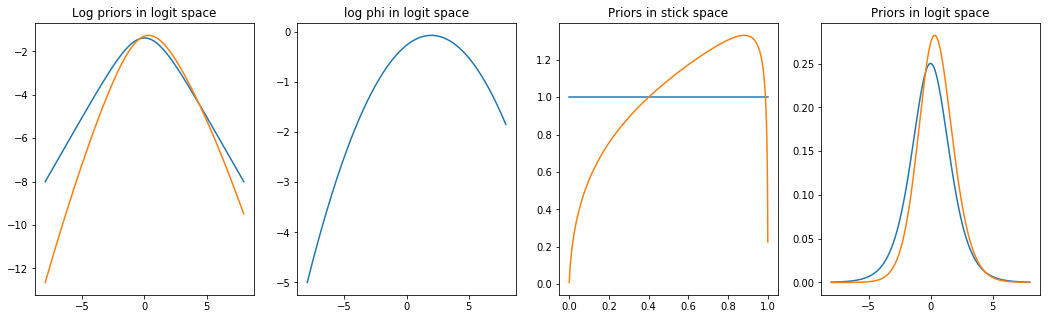

In [105]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


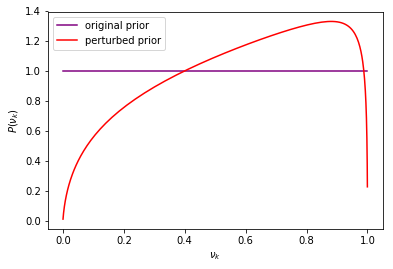

In [107]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)), color = 'purple')
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)), color = 'red')

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/perturbed_prior1_init3_5.png')

In [108]:
prior_plot_array = np.array([v_grid, 
                            np.exp(prior_perturbation.get_log_p0(v_grid)), 
                            np.exp(prior_perturbation.get_log_pc(v_grid))])

In [109]:
# np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2.csv', 
#           prior_plot_array, delimiter = ',')

# Choose the number of GH points.

In [110]:
# Sanity check the perturbation

# gmm_utils.set_gauss_hermite_points(
#     prior_perturbation.model.vb_params, gh_deg=10)
#
# prior_perturbation.set_epsilon(1.0)
# print(prior_perturbation.get_e_log_perturbation(sum_vector=False))
#
# prior_perturbation.set_epsilon(0.5)
# print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

prior_perturbation.set_epsilon(1.0)

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=1)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=2)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

gmm_utils.set_gauss_hermite_points(
    prior_perturbation.model.vb_params, gh_deg=10)
print(prior_perturbation.get_e_log_perturbation(sum_vector=False))

[0.30821716 0.19171525 0.15388017 0.17800435 0.25626511 0.26329537
 0.26505108 0.26546033 0.26557865 0.26561819 0.26563227]
[0.30953713 0.1941732  0.18709448 0.28729958 0.39951249 0.41163288
 0.41480118 0.41562497 0.41588194 0.41597088 0.416003  ]
[0.30953713 0.1941732  0.18709448 0.28729958 0.39951249 0.41163288
 0.41480118 0.41562497 0.41588194 0.41597088 0.416003  ]


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


In [111]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
print(expected_perturbations_list[1])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_list[gh_deg_threshold])
print('Chosen gh_dg = {}, learned threshold = {}, checked_points = {}'
      .format(gh_deg, gh_deg_list[gh_deg_threshold], len(max_diffs)))

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


[0.30953713 0.1941732  0.18709448 0.28729958 0.39951249 0.41163288
 0.41480118 0.41562497 0.41588194 0.41597088 0.416003  ]
[0.30953713 0.1941732  0.18709448 0.28729958 0.39951249 0.41163288
 0.41480118 0.41562497 0.41588194 0.41597088 0.416003  ]
[2.96699590e-16 4.00347863e-16 6.74278207e-16 8.00633903e-16
 4.45049385e-16 4.45049385e-16 3.58670839e-16 5.93399180e-16
 7.41748975e-16 4.45049385e-16 2.77893754e-16 4.00681060e-16
 4.45049385e-16 2.67651204e-16 4.16840632e-16 5.55787509e-16
 1.79335420e-16 4.04566924e-16 5.33911308e-16 4.16840632e-16
 3.86432577e-16 3.86432577e-16 5.79648866e-16 4.28824878e-16
 4.45049385e-16 4.28824878e-16 4.01476805e-16 5.33797150e-16
 2.66877968e-16 4.00347863e-16 5.33797150e-16 5.33797150e-16
 2.77893754e-16 2.85883252e-16 5.55787509e-16 4.01476805e-16
 5.38006259e-16 2.69711283e-16 2.85883252e-16 2.66898575e-16
 4.01476805e-16 4.00433481e-16 3.58670839e-16 1.93216289e-16
 2.67651204e-16 2.96699590e-16 3.58670839e-16 2.66898575e-16
 2.66898575e-16 5.79

In [112]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)
model.objective.logger.initialize()

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.389209078210735	 Objective: -342.81033688510433
Optimization terminated successfully.
         Current function value: -342.810347
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -342.810347
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
         Current function value: -342.810347
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


# Examine Fit 

In [113]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [114]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [115]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(
        pca_fit, bnp_centroids, bnp_cluster_covs)

Text(0,0.5,'PC2')

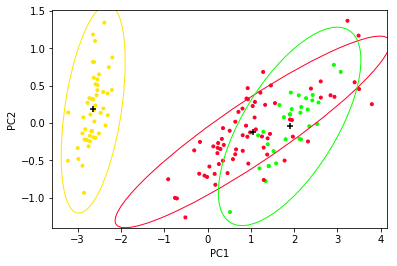

In [116]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

# plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [117]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    sens_lib.ParametricSensitivityLinearApproximation(
        objective_functor=prior_perturbation.get_perturbed_kl,
        input_par=prior_perturbation.model.global_vb_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_val0=best_param_0,
        hyper_val0=np.array([0.0]),
        input_is_free=True,
        hyper_is_free=False,
        hyper_par_objective_functor=prior_perturbation.get_e_log_perturbation)

# epsilon_sensitivity = \
#     obj_lib.ParametricSensitivity(
#         objective_fun=model.set_z_get_kl,
#         input_par=prior_perturbation.model.global_vb_params,
#         output_par=moment_model.moment_params,
#         hyper_par=prior_perturbation.epsilon_param,
#         input_to_output_converter=moment_model.set_moments,
#         optimal_input_par=best_param_0,
#         objective_hessian=kl_hessian_0,
#         hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [118]:
prior_perturbation.set_epsilon(0.0)
print(prior_perturbation.get_e_log_perturbation())

prior_perturbation.set_epsilon(1.0)
print(prior_perturbation.get_e_log_perturbation())

print(np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper()))

-0.0
3.8707828081084394
2.182239886862977


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


## Fit with perturbation

In [119]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
# output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
#     epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  2.182239886862977


In [120]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)


best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


Iter  0  value:  -339.369645719959
Optimization terminated successfully.
         Current function value: -339.473571
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
         Current function value: -339.473571
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.5440035958399343


Epsilon: 1.0


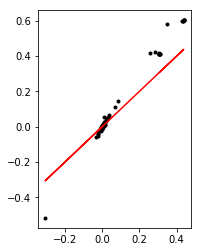

In [121]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [122]:
print('original expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model))

print('perturbed expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi, model))

print('predicted expected number of clusters: ',
      gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi_pred, model))

original expected number of clusters:  3.7035870677702136
perturbed expected number of clusters:  3.7645480988213786
predicted expected number of clusters:  3.815829181306393


# Predict for a range of perturbations

In [123]:
epsilon_vec = np.append(np.linspace(0, 0.1, 6), np.linspace(0.2, 1.0, 6))
print(epsilon_vec)

[0.   0.02 0.04 0.06 0.08 0.1  0.2  0.36 0.52 0.68 0.84 1.  ]


In [124]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

prior_perturbation.objective.logger.print_every = 10

for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = \
        gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi_pred, model)
    
#     epsilon_sensitivity.predict_output_par_from_hyperparameters(
#         epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.objective.logger.initialize()
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

#     output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
    output_phi = \
        gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_phi, model)

    print('Done. Converged: ', converged)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    



Epsilon:  0.0
Predicted differences:  0.0
epsilon: 0.0
Iter  0  value:  -342.8103473495695
         Current function value: -342.810347
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 5.393146009659065e-15


Epsilon:  0.02
Predicted differences:  0.04364479773725954
epsilon: 0.02


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.204306e-07
  AccuracyWarning)


Iter  0  value:  -342.7332244240084
Optimization terminated successfully.
         Current function value: -342.733224
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.04364479773725954
Actual differences: (This is nonzero if phi did anything): 0.0432305730554336


Epsilon:  0.04
Predicted differences:  0.08728959547451898
epsilon: 0.04


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.895273e-07
  AccuracyWarning)


Iter  0  value:  -342.65667703484695
Optimization terminated successfully.
         Current function value: -342.656677
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
         Current function value: -342.656677
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.08728959547451898
Actual differences: (This is nonzero if phi did anything): 0.08565464197624852


Epsilon:  0.06
Predicted differences:  0.1309343932117787
epsilon: 0.06


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.141358e-07
  AccuracyWarning)


Iter  0  value:  -342.5806902977464
Optimization terminated successfully.
         Current function value: -342.580692
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
         Current function value: -342.580692
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.1309343932117787
Actual differences: (This is nonzero if phi did anything): 0.12730371167333548


Epsilon:  0.08


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.000246e-06
  AccuracyWarning)


Predicted differences:  0.17457919094903823
epsilon: 0.08
Iter  0  value:  -342.5052493321908
Optimization terminated successfully.
         Current function value: -342.505256
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -342.505256
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.17457919094903823
Actual differences: (This is nonzero if phi did anything): 0.16820831638445616


Epsilon:  0.1
Predicted differences:  0.2182239886862977
epsilon: 0.1


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.153096e-06
  AccuracyWarning)


Iter  0  value:  -342.4303392615646
Optimization terminated successfully.
         Current function value: -342.430355
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -342.430355
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.2182239886862977
Actual differences: (This is nonzero if phi did anything): 0.20839413746621716


Epsilon:  0.2
Predicted differences:  0.4364479773725954
epsilon: 0.2


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.559457e-06
  AccuracyWarning)


Iter  0  value:  -342.0632319512423
Optimization terminated successfully.
         Current function value: -342.063474
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
         Current function value: -342.063474
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.4364479773725954
Actual differences: (This is nonzero if phi did anything): 0.3994546952395966


Epsilon:  0.36
Predicted differences:  0.7856063592706718
epsilon: 0.36


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.573426e-06
  AccuracyWarning)


Iter  0  value:  -341.4980599849736
Optimization terminated successfully.
         Current function value: -341.500391
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
         Current function value: -341.500391
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  0.7856063592706718
Actual differences: (This is nonzero if phi did anything): 0.6759659978808114


Epsilon:  0.52


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.342575e-06
  AccuracyWarning)


Predicted differences:  1.134764741168748
epsilon: 0.52
Iter  0  value:  -340.95358138337076
Optimization terminated successfully.
         Current function value: -340.962957
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
         Current function value: -340.962957
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  1.134764741168748
Actual differences: (This is nonzero if phi did anything): 0.923651690390317


Epsilon:  0.6799999999999999
Predicted differences:  1.4839231230668242
epsilon: 0.6799999999999999


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.077338e-06
  AccuracyWarning)


Iter  0  value:  -340.42227530777507
Optimization terminated successfully.
         Current function value: -340.447736
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: -340.447736
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  1.4839231230668242
Actual differences: (This is nonzero if phi did anything): 1.1483056936734248


Epsilon:  0.8400000000000001
Predicted differences:  1.8330815049649007
epsilon: 0.8400000000000001


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.322074e-07
  AccuracyWarning)


Iter  0  value:  -339.8967210910173
Optimization terminated successfully.
         Current function value: -339.952007
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
         Current function value: -339.952007
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  1.8330815049649007
Actual differences: (This is nonzero if phi did anything): 1.3540669017516613


Epsilon:  1.0


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.186671e-07
  AccuracyWarning)


Predicted differences:  2.182239886862977
epsilon: 1.0
Iter  0  value:  -339.369645719959
Optimization terminated successfully.
         Current function value: -339.473571
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 0
         Current function value: -339.473571
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
Predicted differences:  2.182239886862977
Actual differences: (This is nonzero if phi did anything): 1.5440035958399343


In [125]:
# np.save('best_param_phi_array', best_param_phi_array)

In [126]:
# output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)
output_0 = \
    gmm_utils.get_e_num_pred_clusters_from_free_par(best_param_0, model)


In [127]:
# for i in range(len(epsilon_vec)): 
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_pred_array[i] - best_param_0, 'k.')
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_array[i] - best_param_0, 'r')
#     plt.xlabel('true diff global free params')
#     plt.ylabel('pred diff global free params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))

#     plt.subplot(1, 2, 2)
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_pred_array[i] - output_0, 'k.')
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_array[i] - output_0, 'r')
#     plt.xlabel('true diff moment params')
#     plt.ylabel('pred diff moment params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
#     plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [128]:
# # This expects the hyperparameter to be at its optimal value.
# #e_num_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
# #e_num_clusters_class = gmm_utils.ExpectedNumClustersFromLogitSticks(model)
# e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

# prior_perturbation.set_epsilon(0.0)
# cluster_sensitivity = \
#     obj_lib.ParametricSensitivity(
#         objective_fun=model.set_z_get_kl,
#         input_par=e_num_clusters_class.model.global_vb_params,
#         output_par=e_num_clusters_class.e_num_clusters,
#         hyper_par=prior_perturbation.epsilon_param,
#         input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
#         optimal_input_par=best_param_0,
#         objective_hessian=kl_hessian_0,
#         hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [129]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(epsilon_vec)):
    e_num_clusters_pred.append(
        gmm_utils.get_e_num_clusters_from_free_par(
            best_param_phi_pred_array[i], model))
    e_num_clusters_true.append(
        gmm_utils.get_e_num_clusters_from_free_par(
            best_param_phi_array[i], model))
    
e_num_post_pred_clusters_pred = []
e_num_post_pred_clusters_true = []
for i in range(len(epsilon_vec)):
    e_num_post_pred_clusters_pred.append(
        gmm_utils.get_e_num_pred_clusters_from_free_par(
            best_param_phi_pred_array[i], model))
    e_num_post_pred_clusters_true.append(
        gmm_utils.get_e_num_pred_clusters_from_free_par(
            best_param_phi_array[i], model))

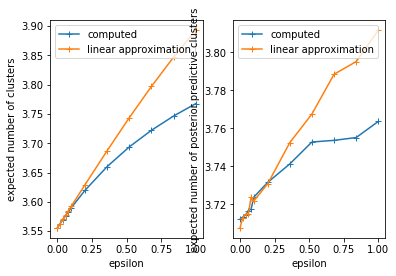

In [130]:
plt.subplot(121)
plt.plot(epsilon_vec, e_num_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.legend(('computed', 'linear approximation'))

plt.subplot(122)
plt.plot(epsilon_vec, e_num_post_pred_clusters_true, '+-')
plt.plot(epsilon_vec, e_num_post_pred_clusters_pred, '+-')
plt.xlabel('epsilon')
plt.ylabel('expected number of posterior predictive clusters')
plt.legend(('computed', 'linear approximation'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/pred_num_clusters1_init3_5.png')

(12, 2, 11)


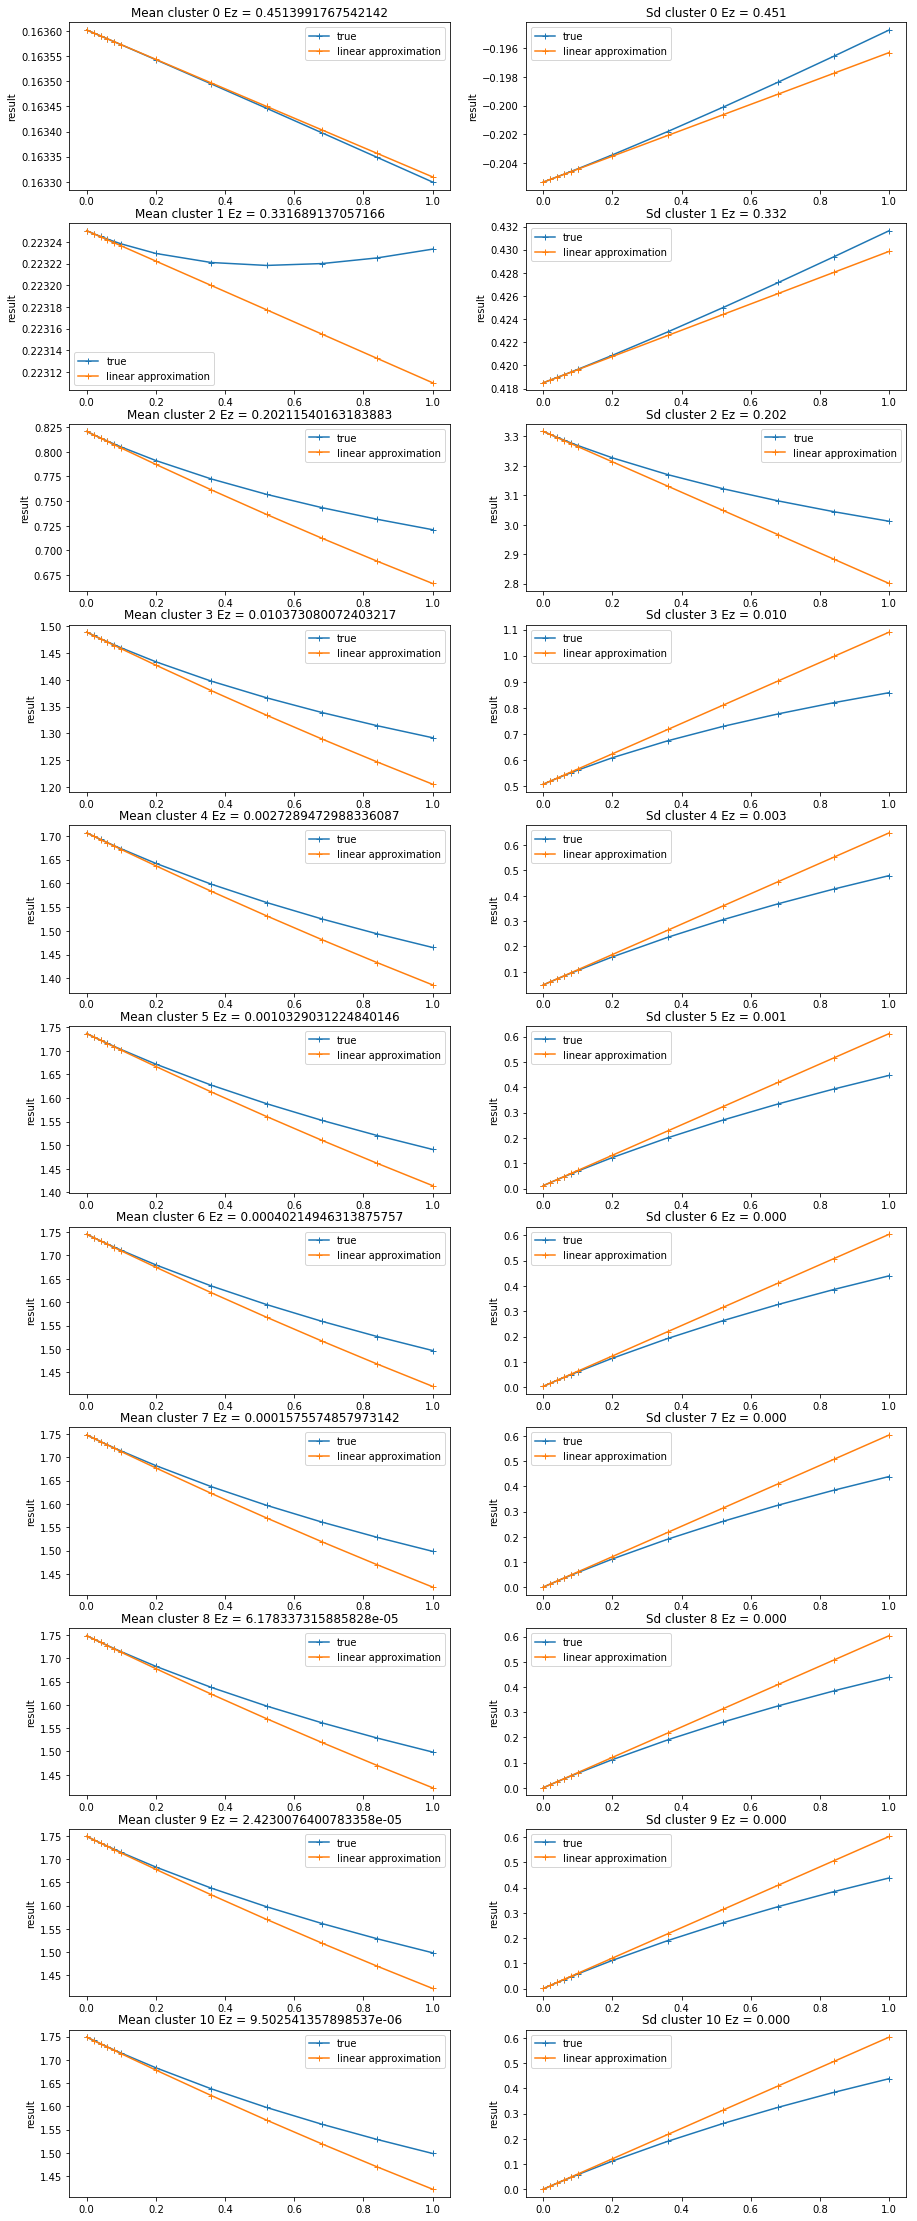

In [186]:
# Look at stick quantities.

cluster_probs = model.get_e_cluster_probabilities()

def get_stick_result(free_par, model):
    model.global_vb_params.set_free(free_par)
    return np.vstack(
        [1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get()), \
         model.global_vb_params['v_sticks']['mean'].get() ])

sticks_true = np.array([ get_stick_result(free_par, model) for free_par in best_param_phi_array ])
sticks_pred = np.array([ get_stick_result(free_par, model) for free_par in best_param_phi_pred_array ])

plt.figure(figsize=(15, 40))
print(sticks_true.shape)
for k in range(model.k_approx - 1):
    plt.subplot(model.k_approx - 1, 2, 2 * k + 1)
    plt.plot(epsilon_vec, sticks_true[:, 0, k], '+-')
    plt.plot(epsilon_vec, sticks_pred[:, 0, k], '+-')
    #plt.xlabel('epsilon')
    plt.ylabel('result')
    plt.title('Mean cluster {0} Ez = {1:0.3f}'.format(k, cluster_probs[k]))
    plt.legend(('true', 'linear approximation'))

    plt.subplot(model.k_approx - 1, 2, 2 * k + 2)
    plt.plot(epsilon_vec, sticks_true[:, 1, k], '+-')
    plt.plot(epsilon_vec, sticks_pred[:, 1, k], '+-')
    #plt.xlabel('epsilon')
    plt.ylabel('result')
    plt.title('Sd cluster {0} Ez = {1:0.3f}'.format(k, cluster_probs[k]))
    plt.legend(('true', 'linear approximation'))

# k = 1
# plt.plot(epsilon_vec, sticks_true[:, k, 0], '+-')
# plt.plot(epsilon_vec, sticks_pred[:, k, 0], '+-')
# plt.xlabel('epsilon')
# plt.ylabel('result')
# plt.legend(('true', 'linear approximation'))


[4.49181561e-01 3.31549565e-01 2.09080149e-01 6.00426429e-03
 2.12541530e-03 1.03351835e-03 5.13256102e-04 2.56208345e-04
 1.28042837e-04 6.40115879e-05 3.20043087e-05 3.20043087e-05]


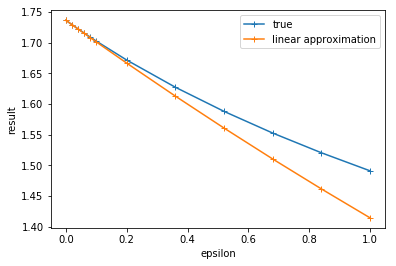

In [142]:
# Look at generic quantities.


model.global_vb_params.set_free(best_param_0)
print(model.get_e_cluster_probabilities())

stick_ind = 5
def get_result(free_par, model):
    model.global_vb_params.set_free(free_par)
    return 1 / np.sqrt(model.global_vb_params['v_sticks']['info'].get()[stick_ind])
    #return model.global_vb_params['v_sticks']['mean'].get()[stick_ind]

result_pred = []
result_true = []
for i in range(len(epsilon_vec)):
    result_pred.append(get_result(best_param_phi_pred_array[i], model))
    result_true.append(get_result(best_param_phi_array[i], model))

    
plt.plot(epsilon_vec, result_true, '+-')
plt.plot(epsilon_vec, result_pred, '+-')
plt.xlabel('epsilon')
plt.ylabel('result')
plt.legend(('true', 'linear approximation'))


In [132]:
np.array(e_num_clusters_true)

array([3.5555023 , 3.56276522, 3.5698225 , 3.57668162, 3.5833503 ,
       3.58983446, 3.61973685, 3.66025814, 3.69384165, 3.72220032,
       3.74653049, 3.76768355])

In [133]:
func_sens_results_array = np.array([epsilon_vec, 
                                   np.array(e_num_clusters_true).squeeze(), 
                                   np.array(e_num_clusters_pred).squeeze()])

# np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2_enum_clust_results.csv', 
#         func_sens_results_array, 
#           delimiter = ',')

In [134]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


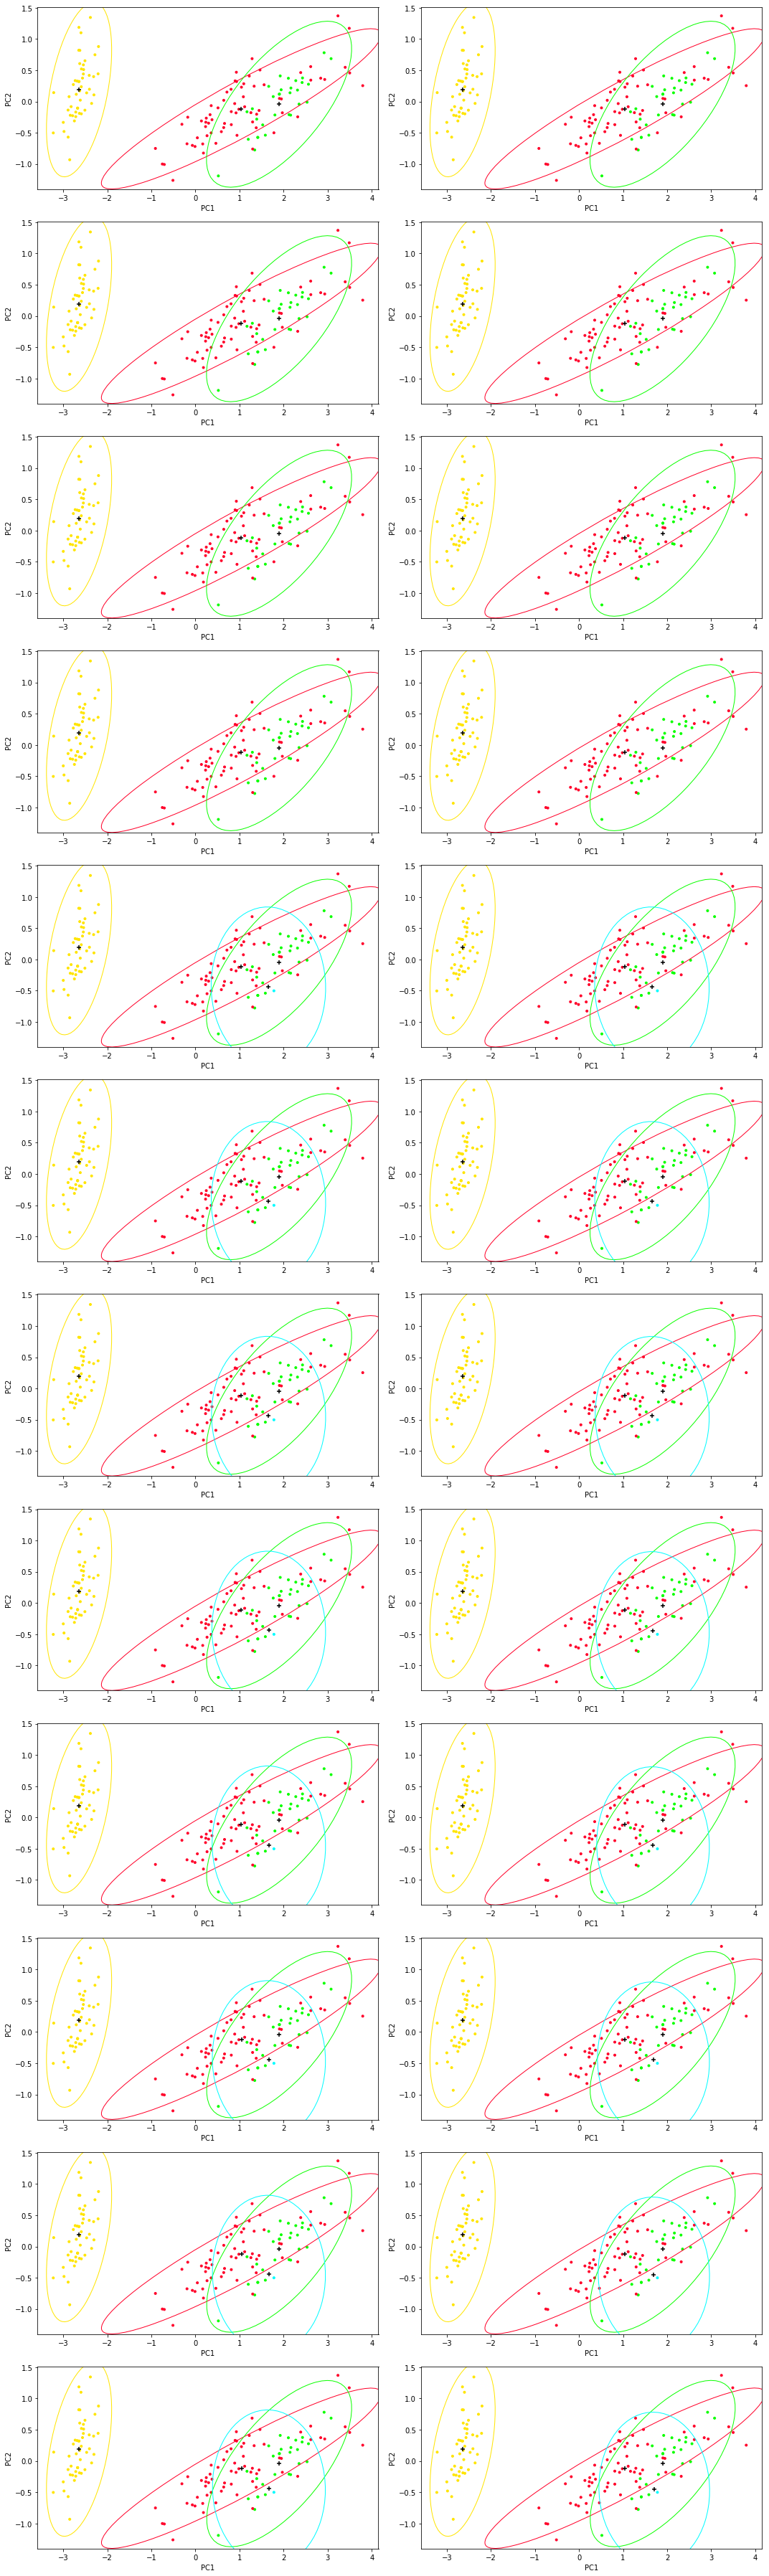

In [135]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()